In [ ]:
# //received fatal error
# git remote remove origin
# git init
# git remote add origin git@github:<yoursite>/<your project>.git
# // still received an err 
# //restarted VSCode and folder via IE 
# //updated one char and resaved the index.html  
# git add .
# git commit -m "blah"
# git push origin master

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import seaborn as sns
import time
from IPython.display import Image
import numpy as np
from matplotlib import cm
from numpy.linalg import pinv
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston

## Vectorization Approach
In this lesson, we starts with the vectorization approach and find the optimum parameters(theta) and cost. Later, we will depicts the regularization ridge and lasso.

## 1) Data Preparation
The analysis will be on one feature of boston housing that is the size of houses and y (target) is price of houses.

In [2]:
# As for the plot customazation, we have the folllowing:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 120

In [3]:
Boston = load_boston()
print(Boston.keys())
# print(Boston.filename)
boston = pd.DataFrame(data=Boston.data, columns=[Boston.feature_names])

boston["target"] = Boston.target
display(boston.head(3))
print(boston.shape)

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


(506, 14)


In [4]:
def normalization(x):
    maximum = np.max(x)
    minimum = np.min(x)
    avg = np.mean(x)
    normality = (x-avg)/(maximum-minimum)
    return normality

In [5]:
# As for the dataframe, default is deepcopy but for the list copy and deepcopy is different
data = boston.copy()
data = data.apply(normalization, axis=0)
print(data.shape)

# Insert X0 Column
#X_New = np.array([np.ones(len(x)), x.flatten()]).T
# x = np.vstack((np.ones(len(x)),x)).T
data.insert(0,"X0",1)
print(data.shape)
data.head(2)

(506, 14)
(506, 15)


,X0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,1,-0.040544,0.066364,-0.323562,-0.06917,-0.034352,0.055636,-0.034757,0.026822,-0.371713,-0.214193,-0.335695,0.101432,-0.211729,0.032604
1,1,-0.040308,-0.113636,-0.149075,-0.06917,-0.176327,0.026129,0.106335,0.106581,-0.328235,-0.317246,-0.069738,0.101432,-0.096939,-0.020729


In [6]:
data.iloc[:,8]
data.columns[8][0]
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values
## We consider feature for one dimension
x= X[:,8]
x.shape

(506,)

## 2) Calculate the y prediction (target) and cost 

### (Equation 1)
$ Y_1 = \theta_0 + \theta_1 X_1 + e_i $

$ Y_1 = \theta_0 + \theta_1 X_1 + e_1 $

$ Y_2 = \theta_0 + \theta_1 X_2 + e_2 $ 
$ ....  = .........+..............+.....\\ $
$ Y_n = \theta_0 + \theta_1 X_n + e_n $ 


### (Equation 1-1)
$$
\left[\begin{array}{c}
Y_1 \\
Y_2 \\
... \\
Y_n 
\end{array}\right] = 
\left[\begin{array}{c}
\theta_0 + \theta_1 X_1\\
\theta_0 + \theta_1 X_2 \\
...... \\
\theta_0 + \theta_1 X_n 
\end{array}\right] + 
\left[\begin{array}{c}
e_1 \\
e_2 \\
.... \\
e_n 
\end{array}\right]
$$

The reason that one is added as the separate column to X is because of the noise (intercept) in our linear equartion that are $\theta_0$, $\theta_1$, $\theta_2$, ... , $\theta_n$ . If we substitute 1 with X_0, We can have $\theta_0 X_0$, $\theta_1 X_0$, $\theta_2 X_0$,....,$\theta_n X_0$. 

### (Equation 1-2)
$$
X =
\left[\begin{array}{c}
1 & X_1^{(1)} & X_2^{(1)} & ....& X_n^{(1)}\\
1 & X_1^{(2)} & X_2^{(2)} & ....& X_n^{(2)}\\
1 & X_1^{(3)} & X_2^{(3)} & ....& X_n^{(3)}\\
.......\\
1 & X_1^{(m)} & X_2^{(m)} & ....& X_n^{(m)}
\end{array}\right]
$$

**Note:** __X is the square matrix. In order to obtain the linear regression equation , we need to transpose both X and theta as follows:__


### (Equation 1-3)
$$
\left[\begin{array}{h}
\theta_0 & \theta_1 & \theta_2 &.....& \theta_n
\end{array}\right] *
\left[\begin{array}{c}
1 \\ X_1^{(1)} \\ X_2^{(1)} \\ ....\\ X_n^{(1)}
\end{array}\right] =
\left[\begin{array}{c}
\theta_0 + \theta_1 X_1^{(1)} + \theta_2 X_2^{(1)} + .....\theta_n X_n^{(1)}\\
\end{array}\right]
$$

### (Equation 1-4)
$$
\left[\begin{array}{h}
\theta_0 & \theta_1 & \theta_2 &.....& \theta_n
\end{array}\right] *
\left[\begin{array}{c}
1 \\ X_1^{(2)} \\ X_2^{(2)} \\ ....\\ X_n^{(2)}
\end{array}\right] =
\left[\begin{array}{c}
\theta_0 + \theta_1 X_1^{(2)} + \theta_2 X_2^{(2)} + .....\theta_n X_n^{(2)}\\
\end{array}\right]
$$
We repeatedly do this above for all the m training samles until we get the last training sample(m)
$$
\theta_0 + \theta_1 X_1^{(m)} + \theta_2 X_2^{(m)} + .....\theta_n X_n^{(m)}
$$

### (Equation 1-5)
$$
\left[\begin{array}{c}
Y_1 \\
Y_2 \\
... \\
Y_n 
\end{array}\right] = 
\left[\begin{array}{c}
1 & X_1\\
1 & X_2 \\
...... \\
1 & X_n 
\end{array}\right] *
\left[\begin{array}{c}
\theta_0 \\
\theta_1
\end{array}\right] 
+ 
\left[\begin{array}{c}
e_1 \\
e_2 \\
.... \\
e_n 
\end{array}\right]
$$

### (Equation 1-5-1)
$$
\left[\begin{array}{c}
\theta_0 & \theta_1 
\end{array}\right] *
\left[\begin{array}{c}
1 & 1\\
X_1 & X_2 \\ 
\end{array}\right] 
+ 
\left[\begin{array}{c}
e_1 \\
e_2 \\
\end{array}\right] =
\left[\begin{array}{c}
\theta_0 + \theta_1 X_1\\
\theta_0 + \theta_1 X_2 \\
\end{array}\right]
$$

### (Equation 1-6)
$$ Y_{(n \times1)}  =  X_{(n \times2)}\theta_{(2_\times1)}$$ 
##### The cocept is $$ \theta^{T} x = x^{T} \theta = X \theta$$ where  $$X = x^T$$ ***As we see above all the x are transpose.***

The visualization of the above transpose matrix X that contain $x^{(1)}$, $x^{(2)}$, ...$x^{(m)}$ is as follows:

<img src='img/normal_equation_detail.png' width='75%'>

## 3) Prediction of Y (Y hypothesis) and Cost


### Equation 2) $$Y = y^{(i)} = \sum_{i=1}^{m} (h_\theta(x^{(i)}) =  \sum_{i=1}^{m} (\theta^T(x^{(i)}) = \sum_{i=1}^{m}(X \theta)$$
### Equation 2-1) $$ y = X \theta = \theta^{T}x $$

### Equation 3)
$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 $$

$$J(\theta) = \frac{1}{2m} [{(X \theta - y)^T (X \theta - y)}]$$


### 3-1) Add one to the DataFrame as X0
As can be seen from equation (1-2), in thetranspose of X matrix, 1 is added as the first column for the constant theta parameters (noise or intercept) of linear regression models

In [7]:
x = np.vstack((np.ones(len(x)),x)).T
print(x.shape)

(506, 2)


In [8]:
## Initialize theta
start_time = time.time()
theta = np.zeros((x.shape[1],1))
# y = y.reshape(-1,1)
def h_theta(x,theta):
    return np.dot(x,theta)
print(h_theta(x,theta).shape)
print(time.time()-start_time)

(506, 1)
0.0008981227874755859


In [9]:
%%time
m = len(x)
def mse_vec(x,y,theta):
#     J_vec = np.dot((np.dot(theta.T,x)-y).T,(np.dot(theta,x)-y))
    J = np.dot((h_theta(x,theta)-y).T, (h_theta(x,theta)-y))
    return (1/(2*m))*J[0][0]

mse_vec(x,y,theta)  

CPU times: user 14.8 ms, sys: 4.48 ms, total: 19.3 ms
Wall time: 13.2 ms


0.000531520316683856

## 4) Evaluate theta and cost, using gradient descent  approach

### Equation 4)
$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} (\sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_{j} $$

$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} [{(X^T)} (X \theta - y)]$$

### Equation 5) $$\theta_{(New)} = \theta_{(Old)} - (alpha) * \frac{\partial J(\theta)}{\partial \theta_j} $$
                                              Where learning_rate = alpha

In [10]:
## Initiating
alpha = 0.0005
iteration = 1000
m = x.shape[0]
n = x.shape[1]
def gradient_descent_uni(theta, x, y, alpha=alpha, iteration=iteration):
    J_list = []
    cost_hist = np.zeros((iteration,1))
    y = y.reshape(-1,1)
    theta = np.zeros((2,1),dtype = float) 

    for i in range(iteration):
        Grad = np.dot(x.T,(h_theta(x,theta)-y))
        theta = theta - (alpha/m)*Grad
        cost_hist[i] = mse_vec(x,y,theta)##array([[10.54720933],[10.54718522]]

        J_list.append(mse_vec(x,y,theta))
    
    return J_list, theta

## 5) Find the best learning rate (alpha) through plotting the cost obtained by gradient descent
In gradient descent approach, finding the best alpha has the highest priority that is effective for the estimation. ***alpha is hyperparameter in which its optimum is obtained through the experiments(plotting)***. In order to find this optimum learning rate, the cost function is plotted. In the following, the alpha range is increased by three multiplication as follows. In this approach, the cost function is retrieved and plotted for each alpha in the list. 

In [52]:
choose_alpha = .00001
alpha_range=[]
while choose_alpha<50:
    alpha_range.append(choose_alpha)
    al = choose_alpha*2.8
    choose_alpha = round(al,5)
print(len(alpha_range),alpha_range)
alpha_range.insert(0,0)
print(len(alpha_range),alpha_range)

15 [1e-05, 3e-05, 8e-05, 0.00022, 0.00062, 0.00174, 0.00487, 0.01364, 0.03819, 0.10693, 0.2994, 0.83832, 2.3473, 6.57244, 18.40283]
16 [0, 1e-05, 3e-05, 8e-05, 0.00022, 0.00062, 0.00174, 0.00487, 0.01364, 0.03819, 0.10693, 0.2994, 0.83832, 2.3473, 6.57244, 18.40283]


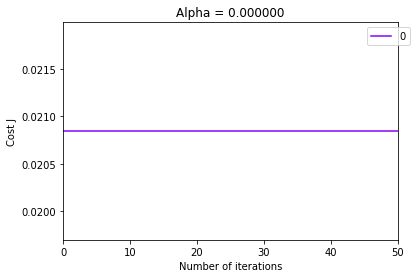

Predicted price = 0.00


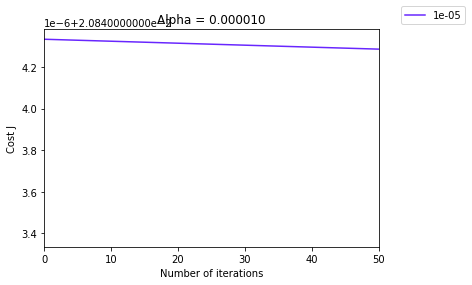

Predicted price = -0.00


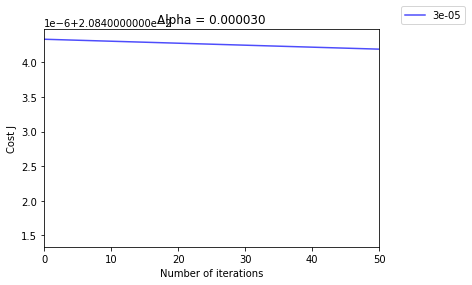

Predicted price = -0.00


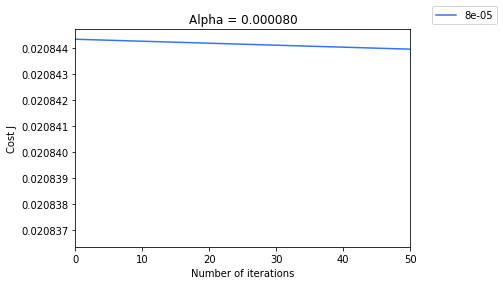

Predicted price = -0.00


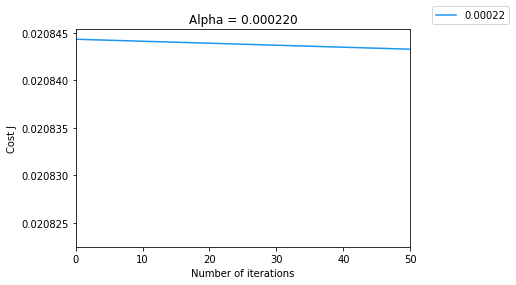

Predicted price = -0.00


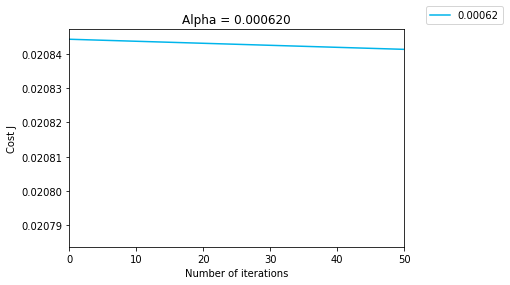

Predicted price = -0.01


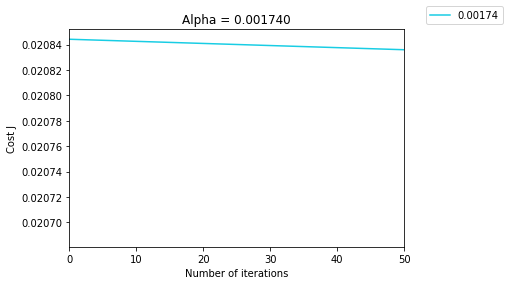

Predicted price = -0.02


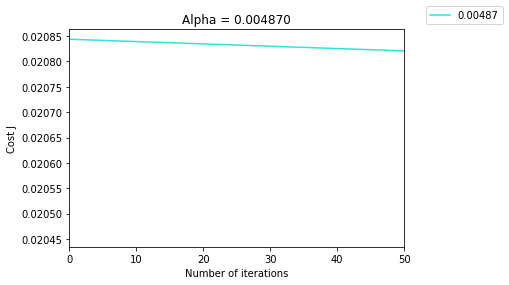

Predicted price = -0.04


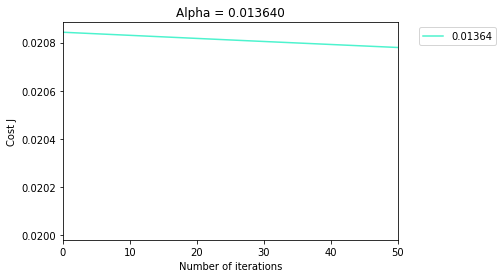

Predicted price = -0.10


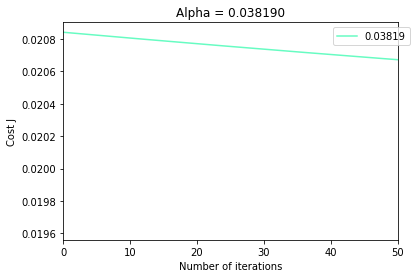

Predicted price = -0.20


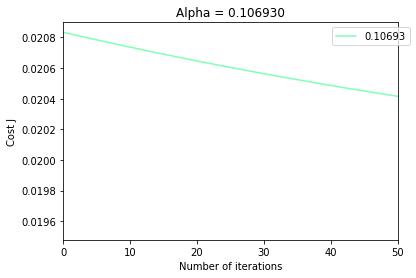

Predicted price = -0.26


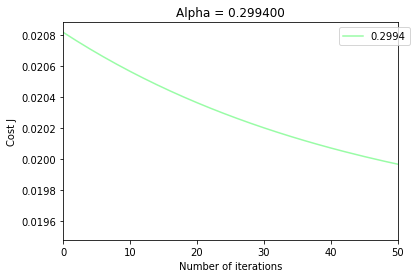

Predicted price = -0.27


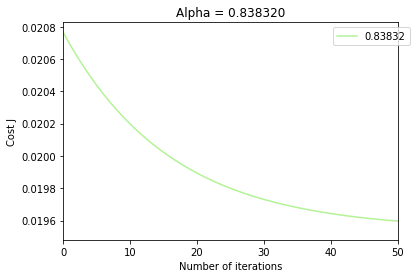

Predicted price = -0.27


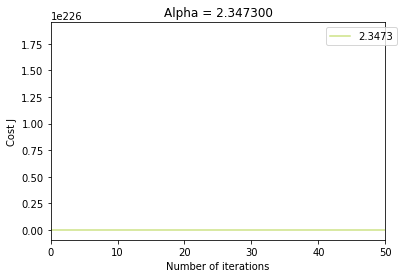

Predicted price = 192870220608844153334307663426658723768754938638498177270113691293048719900453546140861116674024739152120365711360.00


<ipython-input-46-372e47a0319d>:14: RuntimeWarning: invalid value encountered in subtract
  theta = theta - (alpha/m)*Grad


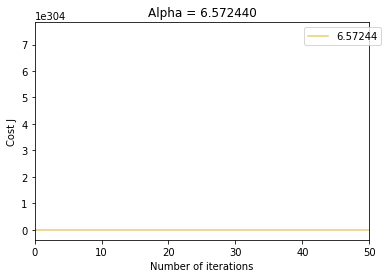

Predicted price = nan


<ipython-input-46-372e47a0319d>:14: RuntimeWarning: invalid value encountered in subtract
  theta = theta - (alpha/m)*Grad


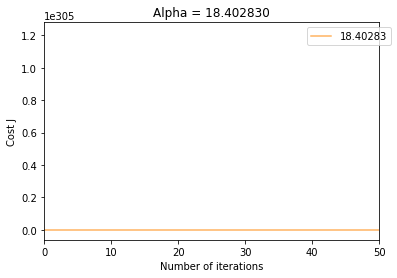

Predicted price = nan


In [53]:
color=cm.rainbow(np.linspace(0,1,n))
def plot_best_alpha():
#     
    alphas = alpha_range
    colours=cm.rainbow(np.linspace(0,1,21))
#     colours = "rgbcymyk" 
    
    for alpha, c in zip(alphas,colours):
        # plot cost versus iteration
        theta = np.zeros((2, 1))
        J_list, newtheta = gradient_descent_uni(theta, x, y, alpha, iteration=1000)
        
        plt.plot(np.arange(1000),J_list, label = alpha, color = c)
        plt.title("Alpha = %f" % (alpha))
        plt.xlabel('Number of iterations')
        plt.ylabel('Cost J')
        plt.xlim([0, 50])
        plt.legend(bbox_to_anchor=(1.05, 1.0))
        plt.show()

#         ## predict price for a 1650 sq feet 3 bedroom house
        x_test = np.array([1650.0, 2])
#         # exclude intercept units when normalizing
        x_test = (x_test - np.mean(x_test)) / np.std(x_test)
        prediction = newtheta.T@x_test
        print('Predicted price = %.2f' % prediction[0])
plot_best_alpha()

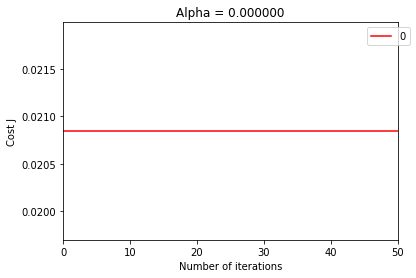

Predicted price = 0.00


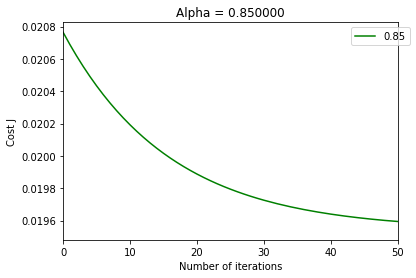

Predicted price = -0.27


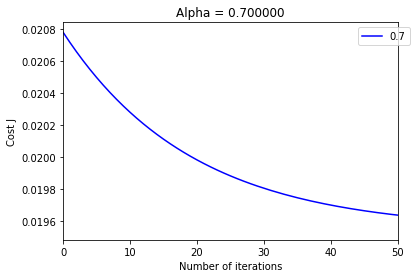

Predicted price = -0.27


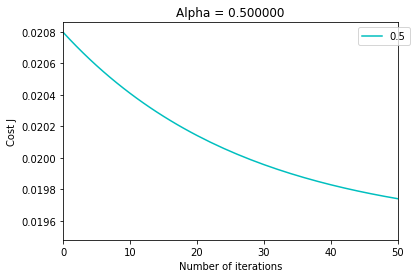

Predicted price = -0.27


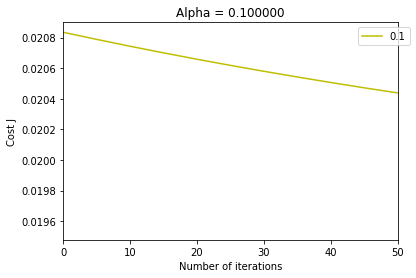

Predicted price = -0.26


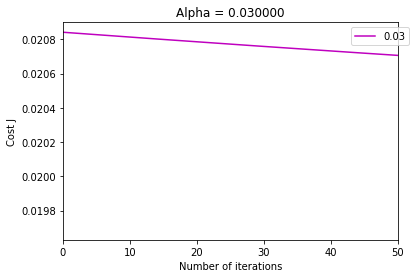

Predicted price = -0.18


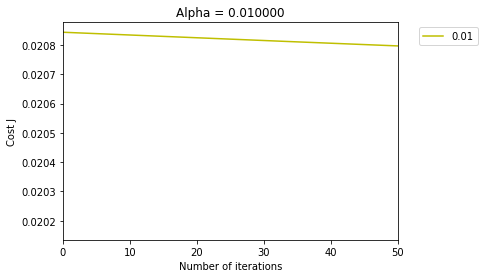

Predicted price = -0.08


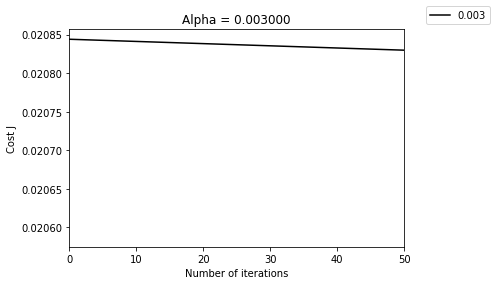

Predicted price = -0.03


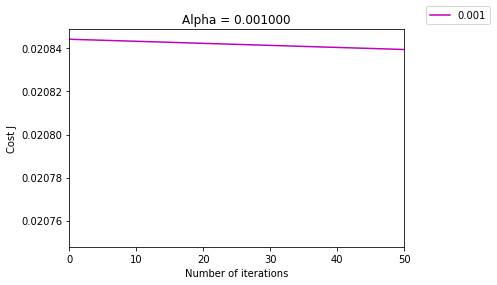

Predicted price = -0.01


In [56]:
def alpha_plotting():
#     
    alphas = [0, 0.85, 0.7, 0.5, 0.1, 0.03, 0.01, 0.003, 0.001]
    colours = "rgbcymykm" 
    
    for alpha, c in zip(alphas,colours):
        # plot cost versus iteration
        theta = np.zeros((2, 1))
        J_list, newtheta = gradient_descent_uni(theta, x, y, alpha, iteration=1000)
        
        plt.plot(np.arange(1000),J_list, label = alpha, color = c)
        plt.title("Alpha = %f" % (alpha))
        plt.xlabel('Number of iterations')
        plt.ylabel('Cost J')
        plt.xlim([0, 50])
        plt.legend(bbox_to_anchor=(1.05, 1.0))
        plt.show()

#         ## predict price for a 1650 sq feet 3 bedroom house
        x_test = np.array([1650.0, 2])
#         # exclude intercept units when normalizing
        x_test = (x_test - np.mean(x_test)) / np.std(x_test)
        prediction = newtheta.T@x_test
        print('Predicted price = %.2f' % prediction[0])
alpha_plotting()

### 5-1) Conclusion of Cost plots:
As can be seen from the above plot,  alpha = 0.85 when we have no learning rate. Based on the above figures, we chose alpha = 0.8 and based on this alpha, we calculate the cost and theta through the gradient descent. THe focus for picking the optimum alpha(learning rate) is the descending trend of the cost function.

In [11]:
J_list, newtheta = gradient_descent_uni(theta, x, y, alpha=0.85, iteration=1000)
newtheta

array([[-1.13625073e-16],
       [ 2.66763537e-01]])

## 5-2)Plotting cost plots against theta_0 and theta_1(3d cost plots)

<ipython-input-58-e43aa6e61b69>:18: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


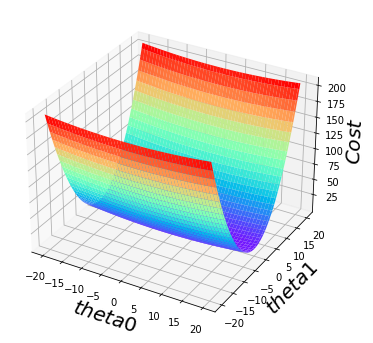

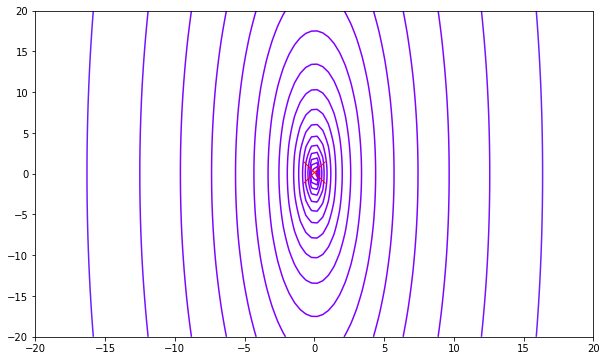

In [58]:
def part1_2():
    # load and prepare data

    # compute cost function for a range of different values for parameters
    theta0_vals = np.linspace(-20, 20, 100)
    theta1_vals = np.linspace(-20, 20, 100)

    J_vals = np.zeros((len(theta0_vals), len(theta1_vals)), dtype=np.float64)
    for i, v0 in enumerate(theta0_vals):
        for j, v1 in enumerate(theta1_vals):
            theta = np.array((theta0_vals[i], theta1_vals[j])).reshape(2, 1)
            J_vals[i, j] = mse_vec(x, y, theta)

    T0, T1 = np.meshgrid(theta0_vals, theta1_vals)

    # plot cost function
    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca(projection="3d")
    ax.plot_surface(T0, T1, J_vals, cmap=plt.cm.rainbow)
    ax.set_xlabel("$theta0$", fontsize=20, rotation=150)
    ax.set_ylabel("$theta1$",fontsize=20, rotation=150)
    ax.set_zlabel("$Cost$", fontsize=20)
    plt.show()

    J_list, newtheta = gradient_descent_uni(theta, x, y, alpha=0.85, iteration=1000)
    fig = plt.figure(figsize=(10, 6))
    plt.contour(T0, T1, J_vals.T, np.logspace(-2, 3.5, 25), cmap=plt.cm.rainbow)
    plt.plot(newtheta[0], newtheta[1], "rx", markersize=22)
    plt.show()

part1_2()

## 5-3) Visualization of y_pred hypotesis , using the optimum theta and alpha from the gradient descent

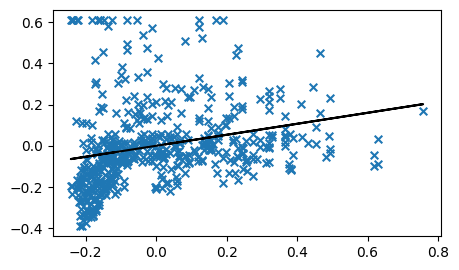

In [59]:
h_theta(x,newtheta).shape
J_list, newtheta = gradient_descent_uni(theta, x, y, alpha=0.85, iteration=1500)
fig = plt.figure(dpi=100, figsize=(5, 3))

# plot data
plt.scatter(x[:,1:2], y, s=30, marker='x')


y_pred = h_theta(x,newtheta)
plt.plot(x[:,1], y_pred, 'k');

In [12]:
from matplotlib import animation, rc
rc('animation', html='html5')
fig = plt.figure(dpi=100, figsize=(5, 3))

# plot data
plt.scatter(x[:,1:2], y, s=30, marker='x')


y_pred = h_theta(x,newtheta)
line, = plt.plot(x[:,1:2], y_pred, 'k');
plt.close()

# J_list, newtheta = gradient_descent_uni(theta, x, y, alpha=0.7, iteration=1000)
# t0,t1 = newtheta[0][0],newtheta[1][0]
def animate(i):
    global t0,t1 
    J_list, newtheta = gradient_descent_uni(theta, x, y, alpha=0.7, iteration=1000)
    line.set_ydata(h_theta(x,newtheta))
    for i in range(100): 
        J_list, newtheta = gradient_descent_uni(theta, x, y, alpha=0.7, iteration=1500)
        t0,t1 = newtheta[0][0],newtheta[1][0]
    return line

anim = animation.FuncAnimation(fig, animate, np.arange(0, 21), interval=200, repeat_delay=1000)

In [62]:
# anim

## 6) Find the best alpha parameters through Normal Equation
THe advantage of normal equation over the gradient descent is there is no hyperparameter learning rate that needs to be evaluated. As for the normal equation, two matrixes that have vector multiplication should be invertable. That is the reason we use pinv instead of inv to avoid the errr of singular matrix due to the invertibility. THere are two reasons that square matrix are not invertible that are as follows:
1)one row or column be the multiplication of another row or column of matrix. 2)n>m(THe number of unknown features are greater than the number of rows/equations, mathematically).

**Goal.** Given $X$ and $y$, our goal is to find $\theta$ through normal equation such that: 
$$X \theta = y$$
1. To solve the above equation for $\theta$, first we multiply both sides by $X^T$
$$X^T X\theta = X^T y$$ 
2. Now, we can compute the **inverse** matrix of $X^T X$ and multiply it on both sides of the above equation.
$$(X^T X)^{-1} (X^T X) \theta = (X^T X)^{-1} X^T y$$ 
Hence, we obtatin

$$\theta = (X^T X)^{-1} X^T y = X^{+} y$$ 

<div class="alert alert-info">
    <strong>Pseudo-inverse:</strong> In the above equation, $X^+$ is called pseudo-inverse.
</div>

In [13]:
def normal_equation(X, y):
    theta = np.linalg.pinv(X.T@X)@(X.T)@y
    return theta
    raise NotImplementedError('You should implement normal_equation function.')
theta_n = normal_equation(x, y)
print(theta_n)
print(pinv(x) @ y)
np.allclose(x @ theta_n, y)

[-1.03541307e-16  2.66763537e-01]
[-1.03541307e-16  2.66763537e-01]


False

# 7) Regularization
Regularization is one of the most effective approaches to overcome overfitting problem. This is used for the multicollinearity of linear regression that leads to the overfitting as the rows and columns of matrix are correlated with each other. First, we explain overfitting to somehow:

**Overfitting:**
- A very common problem in machine learning
- When the model is **much more complex** than it shoud be (i.e. for using a lot of features)
 - it may perform very well on the training data, 
 - but it performs very badly for new (unseen) data.
- In such situations, the model **can not generalize** well.
The plots below illustrate the underfitting, best estimation, and overfitting in order from the left to right.

<img src='img/regression_overfit_fig.png' width='80%'>

### 7-1) How the regularization can help avoid/reduce the overfitting issue?
<h6>Idea:</h6> the idea in regularization is Trying too keep the value of the parameters as small as possible by introducing **penalty for large values**. This overfitting is usually happening when we have polynomial regression and we add new feature to improve the accuracy of the training data. But, the problem is the decreasing of the accuracy of testing/unseen data.
*** __We can have high number of features in polynomial and instead use regularization.__ ***
This is a **multi-objective optimization** problem:
- Trying to learn training data as accurate as possible.
- Trying to predict new data as accurate as possible.


### 7-2)  Regularization term on the normal equation
The normalization term is applied on the theta and cost function obtained by normal equation. Please see that how the theta is obtained through the regularized cost

$$J(\theta) = \frac{1}{2m} [{(X \theta - y)^T (X \theta - y)}+{\lambda \theta^T \theta}]$$
$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} [{(X^T)} (X \theta - y) + \lambda \theta]$$
$$ \frac{\partial J(\theta)}{\partial \theta_j} = (X^TX + \lambda I)\theta - X^T y $$

$$ (X^TX + \lambda I)\theta = X^T y $$

$$ \theta = (X^T X + \lambda I)^{-1} X^T y $$ 

In [14]:
lmbda = 1
theta = np.linalg.inv(np.dot(x.T,x)+lmbda*np.identity(x.shape[1])).dot(x.T).dot(y)
theta

array([-1.07119175e-16,  2.53094596e-01])

__Note__: We want to find the cost function based on this theta from normal equation and draw the plot for each lmbda as follows.:
In our previous cost, we had mse_vec(x,y,theta), but we have Cost_theta_new(X, y, theta, lamb) as follows

## 7-3) Regularized Cost function rom the theta obtained by normal equation

In [15]:

def Cost_regularized(X, y, theta, lamb):
    """
    lamb: lambda, the parameter of regularization
    theta: (n+1)·1 matrix, contains the parameter of x0=1
    X_x0: m·(n+1) matrix, plus x0
    """
    m = len(X)
    h = np.dot(X, theta) # np.dot denotes matrix multiplication
#     J_theta = (((np.dot(X,theta)-y).T).dot(np.dot(X,theta)-y)+(lamb)*(np.dot(theta.T,theta)))
    J_regularized = mse_vec(x,y.reshape(-1,1),theta)+(lamb/(2*m))*(np.dot(theta.T,theta))   
    return J_regularized#, (1/(2*m))*J_theta[0][0]

Cost_regularized(x, y, theta, lamb=1)

0.02093067380791169

### 8) What is Lambda and how to find the optimum value of lambda?
***Note:**
In the above equation, we gave the lambda value equal to 1 randomly and based on that we found the cost function.  However, this selected lambda value is not accurate. 
As we saw in the above, learning rate is hyperparameter and can be achieved by the experiments. As for the learning rate, we plotted the cost function on different iteration and calculated the best learning rate. 

As for the lambda, we will plot the linear regression to find the best degree of polynomial term and best lmbda. lmbda is also hyperparameter as lerning rate.
### 8-1) Lambda and cross validation?
The tuning parameter lambda is chosen by cross validation and has the essential role on the regularization. This lmbda is used as penalties to avoid overfitting. When lambda is small, the focus is on minimizing the error(the least squares estimates in linear regression) and therefore the regression plot is very smooth(it is shown later). As lmbda increases, shrinkage occurs. In L1 norm(lasso), lmbda causes that variables/features that are at zero can be thrown away(feature selection). In L2 norm(Ridge), lmbda keeps all variables and shrinks the coefficients towards zero.

### 8-2) How to use cross validation with regularization?
The answer is where lambda come into account. This is where we need to determine what lambda need to be used when 𝜆0<𝜆1<𝜆2<....<𝜆N. We want to choose the 𝜆(lambda) that is balance between cross validation and regularization.   Cross validation is focusng on choosing the "best" model, that is the model with least training error, while the regularization is focusing on simplifying/smoothifying the model. THis is how it works:
We divide our dataset into 𝑛 subsamples, where 𝑛 is the number of cross-validation folds. This is shown with cv in sklear. k-1 is used for training. For each 𝜆(lambda), compute the cross-validated error when training the model with regularization parameter 𝜆. It trains on all the other folds and compute the error on the test fold. Finally, we choose the 𝜆 which gave the lowest cross-validated error    

### 9) Polynomial features: 
Polynomial regression is a special case of linear regression.  Polynomial regression fits a nonlinear relationship between the value of x and the corresponding target(y), denoted E(y | x), and has been used to describe nonlinear phenomena such as the progression of disease epidemics. We can choose the degree of polynomial based on the relationship between target and explanatory variables(x). The 1-degree polynomial is a simple linear regression (that is 𝜆(lambda) is zero and means no regularization); therefore, the value of degree must be greater than 1. polynomial features are the combinations of the features with degree less than or equal to the specified degree. Those polynomial features created by raising existing features to an exponent. For example, if a dataset had one input feature X, then a polynomial feature would be the addition of one new feature (column) where values were calculated by squaring the values in X, e.g. X^2.

With the increasing degree of the polynomial, the complexity of the model also increases that will cause the ovefitting. With scikit learn, it is possible to create Polynomial regression in a pipeline, shown below

In [32]:
def fit_poly(x, y, degree):
    
    # add polynomial features
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    
    # create and fit the model
    linear_regression = LinearRegression()
    model = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    model.fit(x, y)
    return model
print(fit_poly(x, y, degree=3))
model.steps[1][1]

Pipeline(steps=[('polynomial_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('linear_regression', LinearRegression())])


LinearRegression()

As for the above function,  include_bias essentially just adds a column of ones to the dataframe. We set it to False.

## 9-1) Polynomia degree plots and overfitting without the regularization for the theta obtained by Normal Equation
The code below is aiming to increase the degree of polynimial term and plot the prediction of polynomial for the sample test as follows. The scores is cross validation score that compute the error on the reserved fold(test data) ; then average out the error.

In [21]:
degrees = [1,2,3,4,5,7,9,10]

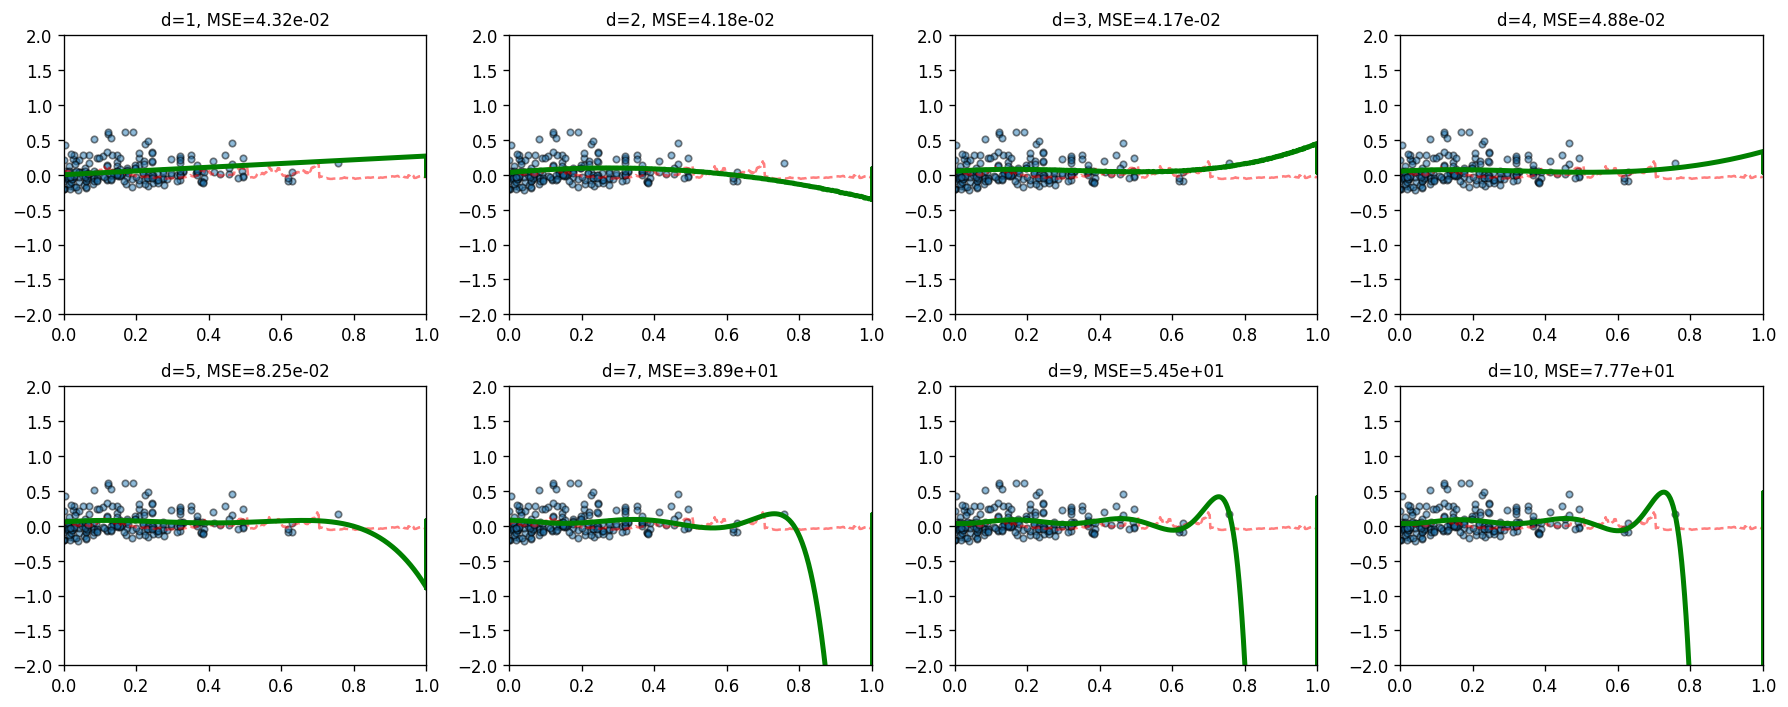

In [22]:
plt.figure(figsize=(15,6))
for d in degrees:
#     model = fit_poly_L2_reg(degree=d, lmbda=lmbda)
    model = fit_poly(x, y, degree=d)
    scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)
    
    # plot data and model
    plt.subplot(2, 4, degrees.index(d) + 1)#h_theta
    plt.tight_layout()
    
    x_test = np.linspace(0, 1, 506)
    plt.plot(x_test, np.dot(x, theta).ravel(), 'r--', label="Target", alpha=0.5)##targetted plot for prediction
    plt.scatter(x[:,1], y, s=15, edgecolor='k', alpha=0.5, label="Samples")## Sample plots
    x_test = np.vstack((np.ones(len(x_test)),x_test)).T
    plt.plot(x_test, model.predict(x_test), 'g', lw=3, label="Predicted")##predicted model (using sklearn polynomia for x_test)
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.title("d={}, MSE={:.2e}".format(d, -scores.mean()), fontsize=10)

plt.show()

For the above polynomia, we can see the ovefitting with the increase of polynomial degree term. In the above, there is no regularization, and is only focusing on the minimizing the error of training that caused overfitting. In the above, degree 3 has the best estimation.

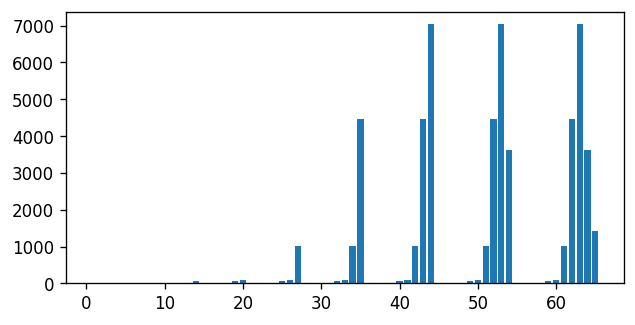

In [23]:
def plot_coef(theta):
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(1, len(theta) + 1), height=np.abs(theta))
    plt.show()
plot_coef(model.steps[1][1].coef_.ravel())

As can be seen from the above, the theta coefficients are very large. Therefore, it will cause the overfitting. We chose the best degree 3 and do We need to use the regularization as follows

## 9-2) Polynomia best degree and  regularization (lambda)
In the below, we chose the Ridge (l2 norm) regularization.
From the above, we chose the degree 3 and based on that we will find the best lambda as follows:

In [34]:
def fit_poly_L2_reg(degree, lmbda):
    # add polynomial features
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    
    # create and fit the model
    linear_regression = Ridge(alpha=lmbda)
    model = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    model.fit(x, y)
    return model
# model.predict(x[:, None])

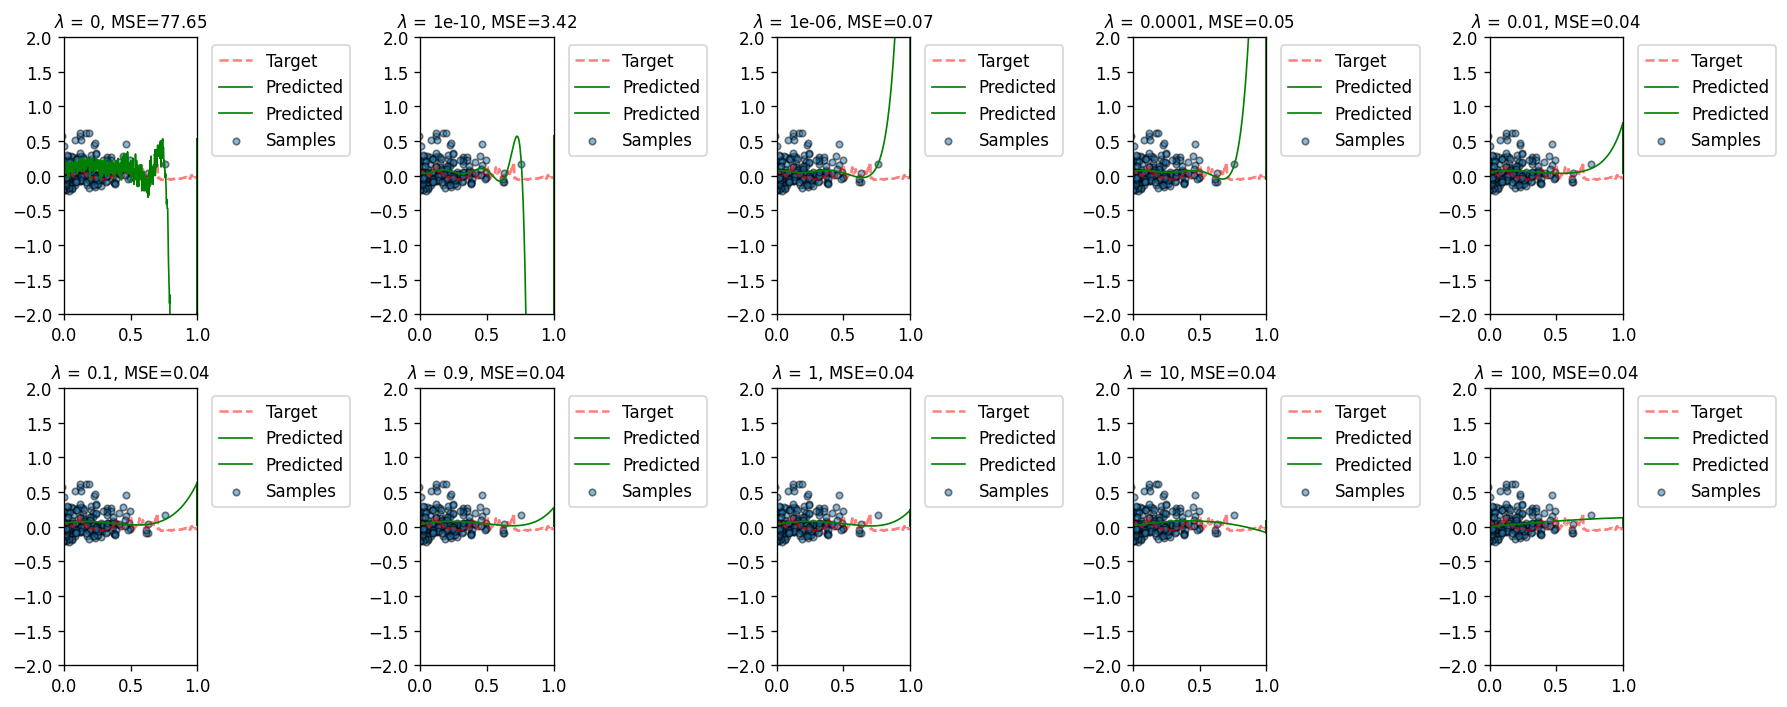

In [36]:
lmbdas = [0, 1e-10, 1e-6, 1e-4, 1e-2, 1e-1, 0.9, 1, 10, 100]
degree = 3
plt.figure(figsize=(15,6))

for lmbda in lmbdas:
    model = fit_poly_L2_reg(degree=d, lmbda=lmbda)
    scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)
#     print(scores)
    
    # plot data and model
    plt.subplot(2, 5, lmbdas.index(lmbda) + 1)
    plt.tight_layout()
    x_test = np.linspace(0, 1, 506)
    plt.plot(x_test, np.dot(x, theta).ravel(), 'r--', label="Target", alpha=0.5)
    plt.scatter(x[:,1], y, s=15, edgecolor='k', alpha=0.5, label="Samples")
    x_test = np.vstack((np.ones(len(x_test)),x_test)).T
    plt.plot(x_test, model.predict(x_test), 'g', lw=1, label="Predicted")
#     plt.subplots_adjust(wspace=2, hspace=.4)
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.title("$\lambda$ = {}, MSE={:.2f}".format(lmbda, -scores.mean()), fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

For lmbda=0 the cost plot is very smooth and is the straight line. In this situation, we have underfit. THis is because the focus is on the first term that is error instead of the regularization term with lmbda. As lmbda is increased, we see that our model wants to fit the training dataset more and more. 

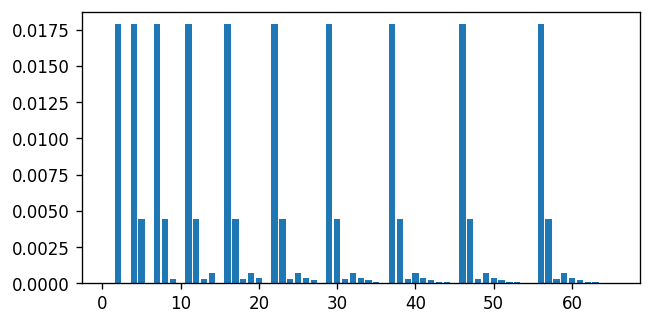

In [37]:
def plot_coef(theta):
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(1, len(theta) + 1), height=np.abs(theta))
    plt.show()
plot_coef(model.steps[1][1].coef_.ravel())

As can be seen from the above graph, the coefficients that were very high and big in the 9-1) section, they became very small. This shows that how the regularization prevent the coefficients from getting too large and in this way help to avoid/reduce the overfitting.

***From the above figure, we chose lmbda (the balance coefficient between the error term and regularization) equal to lmbda = 0.9 and degree=3***
### 9-2-1) Plotting Polynomia best degree and best regularization

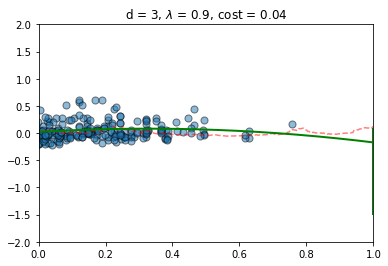

In [81]:
lmbda = 0.9
degree = 3
# fit
model = fit_poly_L2_reg(degree, lmbda)
scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)

# # plot
x_test = np.linspace(0, 2, 506)
plt.plot(x_test, np.dot(x, theta), 'r--', label="Target", alpha=0.5)
plt.scatter(x[:,1], y, s=50, edgecolor='k', alpha=0.5, label="Samples")
x_test = np.vstack((np.ones(len(x_test)),x_test)).T
plt.plot(x_test, model.predict(x_test), 'g', lw=2, label="Predicted")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.title("d = %d, $\lambda$ = %s, cost = %.2f" % (degree, lmbda, -scores.mean()), fontsize=12)
plt.show()

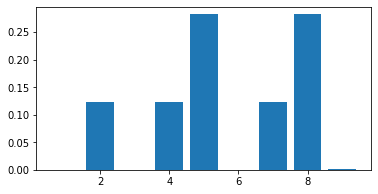

In [82]:
def plot_coef(theta):
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(1, len(theta) + 1), height=np.abs(theta))
    plt.show()
plot_coef(model.steps[1][1].coef_.ravel())

In the above figure, the coefficients are very small as they are already regularized.
***Note:***
There is also another regularization that is L1 notm(lasso) that will be depicted in the gradient descent section.

## 10) Polynomia degree plots and overfitting without the regularization with optimum theta from the gradient descent


<h3 align="center">$$J(\theta) = Cost(X, y, \theta) + \lambda R(\theta)$$</h3>

## 10-1) Polynomia degree plots without the regularization 
$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 $$
$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} [{(X^T)} (X \theta - y)$$

In [95]:
x = X[:,1]
def fit_poly(x, y, degree=1):
    # add polynomial features
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    
    # create and fit the model
    linear_regression = LinearRegression()
    model = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    model.fit(x[:, None], y)
    return model

In [96]:
def h_theta(x,theta):
#     theta = np.zeros(2)
    return np.dot(x,theta)

y_pred = h_theta(np.vstack((np.ones(len(x)),x)).T,newtheta)
y_pred.shape

(506, 1)

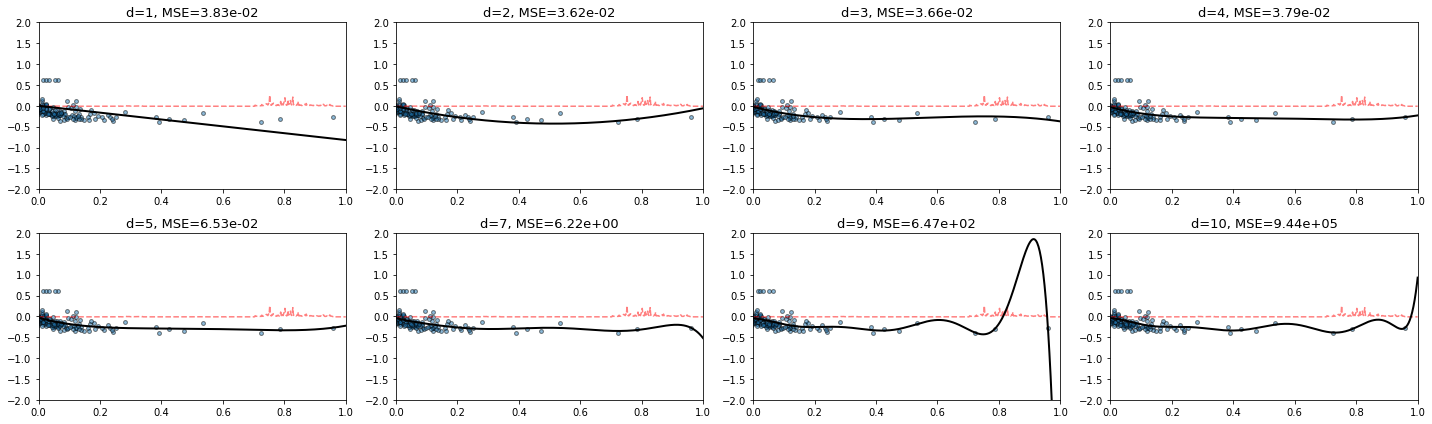

In [97]:
plt.figure(figsize=(20,6))

for d in degrees:
    model = fit_poly(x, y, degree=d)
    scores = cross_val_score(model, x[:, None], y, scoring="neg_mean_squared_error", cv=10)
    
    # plot data and model
    plt.subplot(2, 4, degrees.index(d) + 1)#h_theta
    plt.tight_layout()
    
    x_test = np.linspace(0, 1, 506)
    plt.plot(x_test, y_pred, 'r--', label="Target", alpha=0.5)
    plt.scatter(x, y, s=15, edgecolor='k', alpha=0.5, label="Samples")
    plt.plot(x_test, model.predict(x_test[:, None]), 'k', lw=2, label="Predicted")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.title("d={}, MSE={:.2e}".format(d, -scores.mean()), fontsize=13)

plt.show()

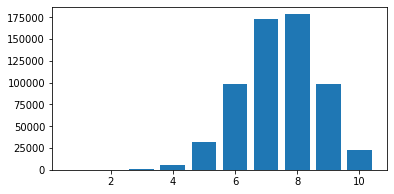

In [98]:
def plot_coef(theta):
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(1, len(theta) + 1), height=np.abs(theta))
    plt.show()
plot_coef(model.steps[1][1].coef_.ravel())

As can be seen from the above plot, the scale of polynomial coefficients are very large that reveal the necessity of going through the regularization that will be illustrated in the next part. 

From the above plots, I chose degree 3 that has less overfitting and MSE is also small.
#### The issue of polynmia model without the regularization is  :
The problem is that the coeficients of theta parameters are getting very big when we do not use the regularization. This means when we increase the degree of  polynimia coeficients(add new features), the error of training(Predict-samples) is decreaed while the test error(predict-target) is increased. The new sample will be on the target and when this test error is increased, that means overfitting occurs and the model cannot work properly on the new sample. 

That is the reason we put the regularization that is as penalties, aiming to shrink the regression coefficient. This means that it prevent the theta from getting very large. THis is added as the ridge and lasso as penalty parameter of theta to the cost function as was defined above. The lambda is the regularization coefficients that make the balance between the terms of regularization and the sum of squared error. 
__The tuning parameter lambda is chosen by cross validation. When lambda is small, the result is essentially the least squares estimates. As lambda increases, shrinkage occurs so that variables that are at zero can be thrown away.__

## 10-2) Polynomia degree plots with the regularization(theta from gradient descent)

$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2$$
$$J(\theta) = \frac{1}{2m} [{(X \theta - y)^T (X \theta - y)}+ {\lambda} {\theta}^T{\theta}]$$


$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} [{(X^T)} (X \theta - y)+{\lambda}\theta)]$$



In [105]:
def fit_poly_L2_reg(degree=degree, lmbda=lmbda):
    # add polynomial features
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)

    # create and fit the model
    linear_regression = Ridge(alpha=lmbda)
    model = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    model.fit(x, y)
    return model
model.steps[1]

('linear_regression', Ridge(alpha=0.01))

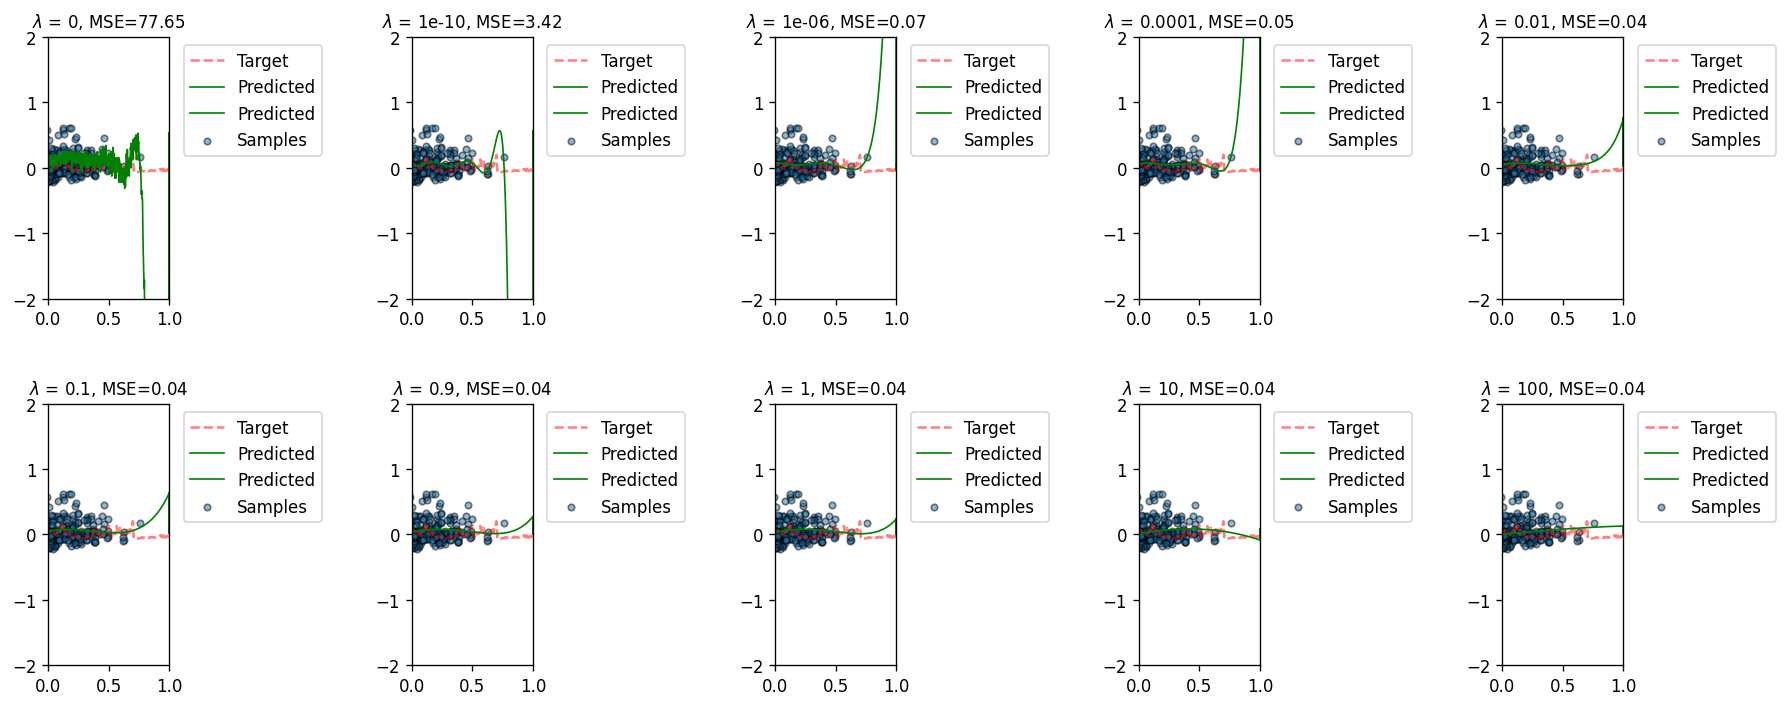

In [72]:
lmbdas = [0, 1e-10, 1e-6, 1e-4, 1e-2, 1e-1, 0.9, 1, 10, 100]
degree = 3
# def h_theta(x,theta):
#     return np.dot(x,theta)
y_pred = h_theta(x,newtheta)

plt.figure(figsize=(15,6))

for lmbda in lmbdas:
    model = fit_poly_L2_reg(degree=d, lmbda=lmbda)
    scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)
#     print(scores)
    
    # plot data and model
    plt.subplot(2, 5, lmbdas.index(lmbda) + 1)
    plt.tight_layout()
    x_test = np.linspace(0, 1, 506)
    plt.plot(x_test, y_pred, 'r--', label="Target", alpha=0.5)
    plt.scatter(x[:,1], y, s=15, edgecolor='k', alpha=0.5, label="Samples")
    x_test = np.vstack((np.ones(len(x_test)),x_test)).T
    plt.plot(x_test, model.predict(x_test), 'g', lw=1, label="Predicted") 
    plt.subplots_adjust(wspace=2, hspace=.4)
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.title("$\lambda$ = {}, MSE={:.2f}".format(lmbda, -scores.mean()), fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In the above plots: When λ=0, the penalty term has no effect, and ridge regression will produce the classical least square coefficients. However, as λ(lambda) increases to infinite, the impact of the shrinkage penalty grows, and the ridge regression coefficients will get close zero.


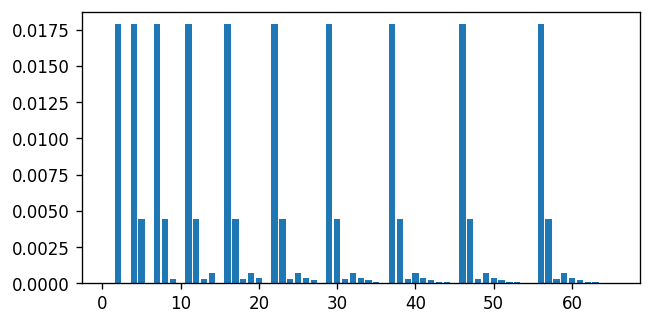

In [69]:
def plot_coef(theta):
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(1, len(theta) + 1), height=np.abs(theta))
    plt.show()

plot_coef(model.steps[1][1].coef_.ravel()) 

As can be seen the above coefficients are much smaller than those coefficients in the part 10-1) that was without the regularization. This shows that how the regularization overcome the overfitting for theta from gradient descents also. 
From the above figures, we chose the degree 3 and lmbda 1e-2 and do plottings as follows.

### 10-2-1) Plotting Polynomia best degree and best regularization for the theta from gradient descents

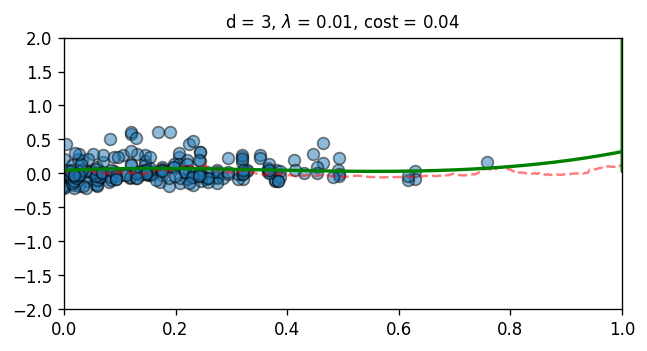

In [94]:
degree = 3
lmbda = 1e-2
# fit
model = fit_poly_L2_reg(degree, lmbda)
scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)

# # plot
plt.figure(figsize=(6,3))
x_test = np.linspace(0, 2, 506)
plt.plot(x_test, y_pred, 'r--', label="Target", alpha=0.5)
plt.scatter(x[:,1], y, s=50, edgecolor='k', alpha=0.5, label="Samples")
x_test = np.vstack((np.ones(len(x_test)),x_test)).T
plt.plot(x_test, model.predict(x_test), 'g', lw=2, label="Predicted")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.title("d = %d, $\lambda$ = %s, cost = %.2f" % (degree, lmbda, -scores.mean()), fontsize=10)
plt.show()

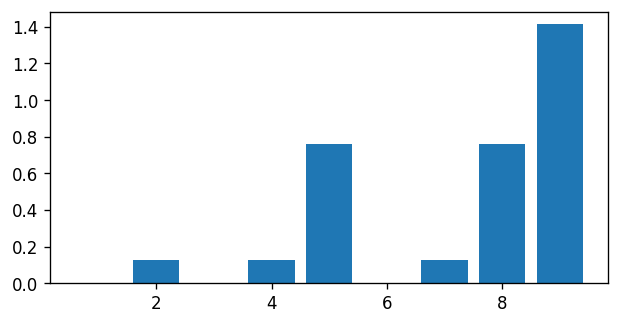

In [95]:
def plot_coef(theta):
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(1, len(theta) + 1), height=np.abs(theta))
    plt.show()
plot_coef(model.steps[1][1].coef_.ravel()) 

We will see the small coefficients for the optimum polynomial model with degree 3 and lambda 1e-2.
In the following, we will also plotted it for the highest polynomial degree that is 10 to compared the results with the degree 3.

### 10-2-2) Plotting Polynomia degree 10 and best regularization for the theta from gradient descents¶

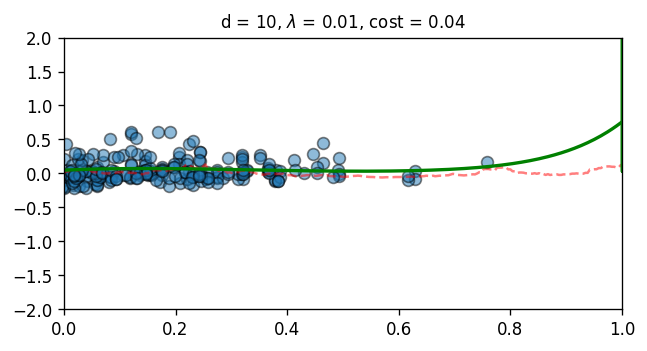

In [96]:
degree = 10
lmbda = 1e-2

# fit
model = fit_poly_L2_reg(degree, lmbda)
scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)

model = fit_poly_L2_reg(degree, lmbda)
scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)

# # plot
plt.figure(figsize=(6,3))
x_test = np.linspace(0, 2, 506)
plt.plot(x_test, y_pred, 'r--', label="Target", alpha=0.5)
plt.scatter(x[:,1], y, s=50, edgecolor='k', alpha=0.5, label="Samples")
x_test = np.vstack((np.ones(len(x_test)),x_test)).T
plt.plot(x_test, model.predict(x_test), 'g', lw=2, label="Predicted")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.title("d = %d, $\lambda$ = %s, cost = %.2f" % (degree, lmbda, -scores.mean()), fontsize=10)
plt.show()

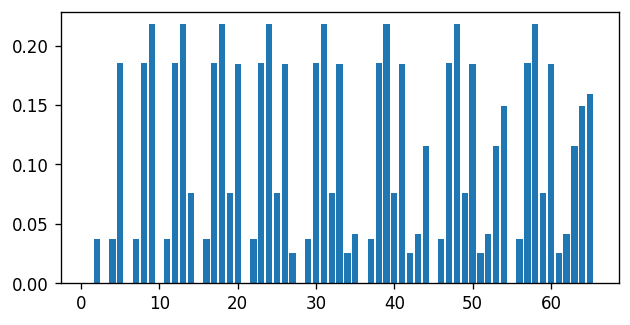

In [98]:
def plot_coef(theta):
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(1, len(theta) + 1), height=np.abs(theta))
    plt.show()
plot_coef(model.steps[1][1].coef_) 

We wil see the low parameter of theta coefficients for all that shows the importane of regularization.

### 10-3) Comparing the coefficient plot for degree 3 and degree 10?

With the increase of degree of polynimial, the error of training(Predict-samples) is decreaed while the test error(predict-target) is increased. The new sample will be on the target and when this test error is increased, that means overfitting as the model cannot work properly on the new sample. 

When we have the ovefitting that coefficients are very big. We plotted the coefficients of the last plot with degree 10.

## 11) L1-Regularizarion (Lasso)

$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 + \frac{\lambda}{m} \sum_{j=1}^{n} |\theta_j|$$

In [151]:
def fit_poly_L1_reg(degree, lmbda):
    
    # add polynomial features up to degree
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    l1_regression = Lasso(alpha=lmbda)
    model = Pipeline([("poly", polynomial_features), ("l1_reg", l1_regression)])
    
    # create and fit the model
    model.fit(x, y)
    return model
model.steps[1][1].coef_

array([0., 0.])

/Users/faezehghazi/Desktop/projects/env/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/faezehghazi/Desktop/projects/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/faezehghazi/Desktop/projects/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.888407121617773, tolerance: 0.0021094466871614706
  model = cd_fast.enet_coordinate_descent(
/Users/faezehghazi/Desktop/projects/env/lib/python3.9/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm d

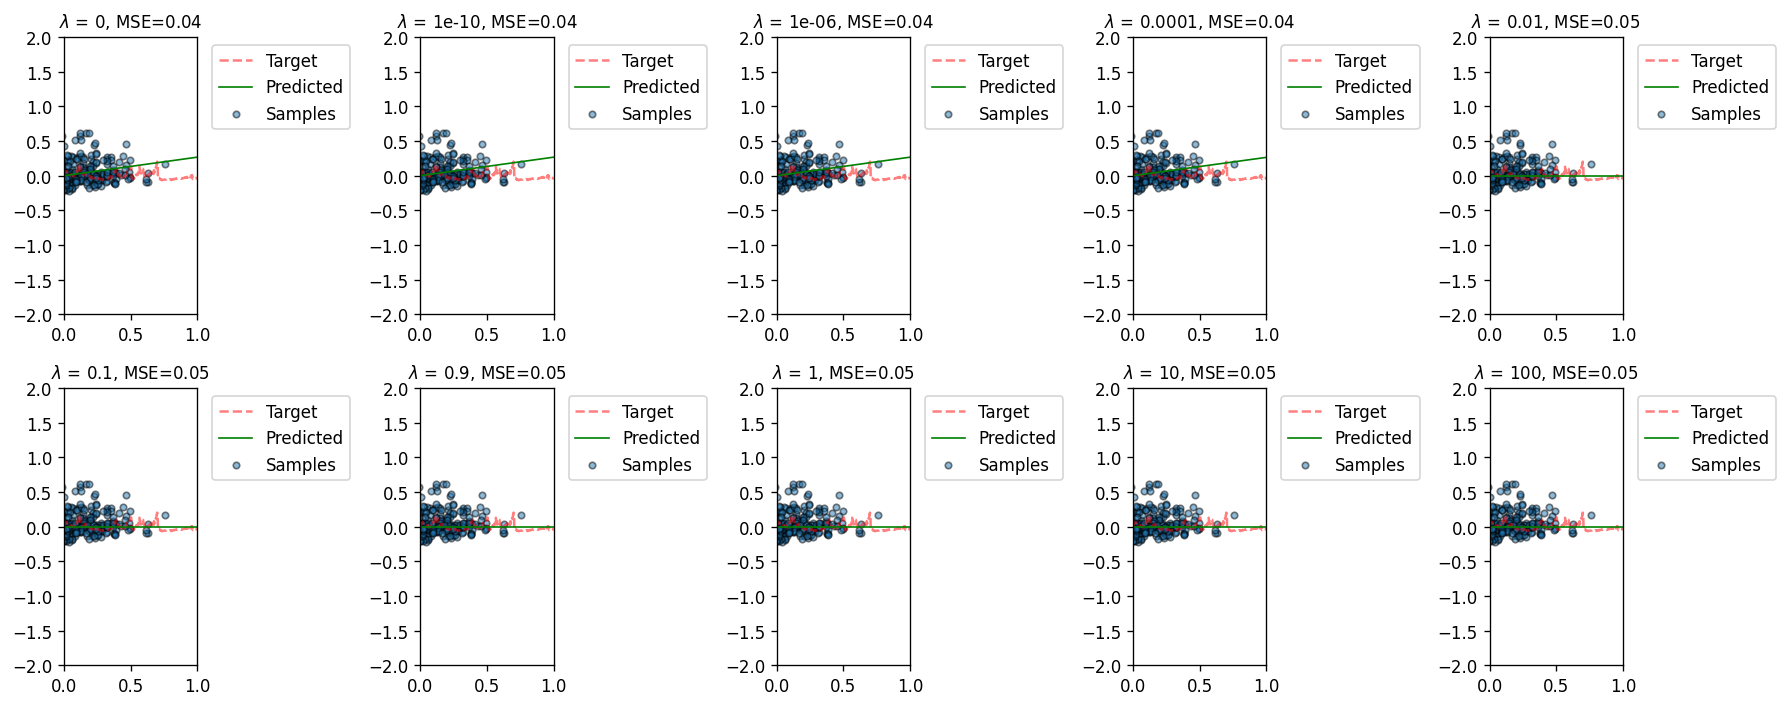

In [149]:
lmbdas = [0, 1e-10, 1e-6, 1e-4, 1e-2, 1e-1, 0.9, 1, 10, 100]
degree = 3
# def h_theta(x,theta):
#     return np.dot(x,theta)
y_pred = h_theta(x,newtheta)

plt.figure(figsize=(15,6))

for lmbda in lmbdas:
    model = fit_poly_L1_reg(degree=d, lmbda=lmbda)
    scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)

    # plot data and model
    plt.subplot(2, 5, lmbdas.index(lmbda) + 1)
    plt.tight_layout()
    x_test = np.linspace(0, 1, 506)
    plt.plot(x_test, y_pred, 'r--', label="Target", alpha=0.5)
    plt.scatter(x[:,1], y, s=15, edgecolor='k', alpha=0.5, label="Samples")
#     x_test = np.vstack((np.ones(len(x_test)),x_test)).T
    plt.plot(x_test, model.predict(np.vstack((np.ones(len(x_test)),x_test)).T), 'g', lw=1, label="Predicted") 
#     plt.subplots_adjust(wspace=2, hspace=.4)
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.title("$\lambda$ = {}, MSE={:.2f}".format(lmbda, -scores.mean()), fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

As we see, lasso L1 norrm performs shrinkage and makes some coefficients zero. The lasso tends to give a set of zero regression coefficients and leads to a sparse solution. It acts like feature selection. 
From the above plots, I picked lmbda = 1e-4

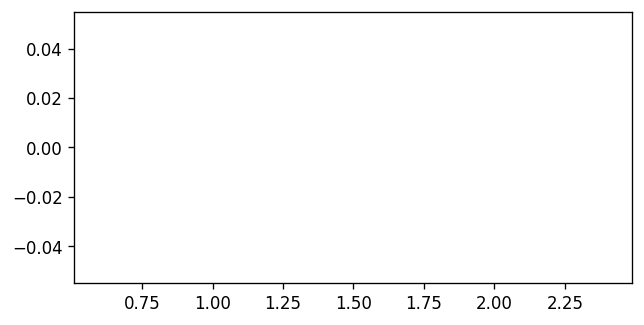

In [150]:
def plot_coef(theta):
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(1, len(theta) + 1), height=np.abs(theta))
    plt.show()
plot_coef(model.steps[1][1].coef_) 

### 11-1) Plotting Polynomia best degree and best regularization(Lasso(L1)) for the theta from gradient descents

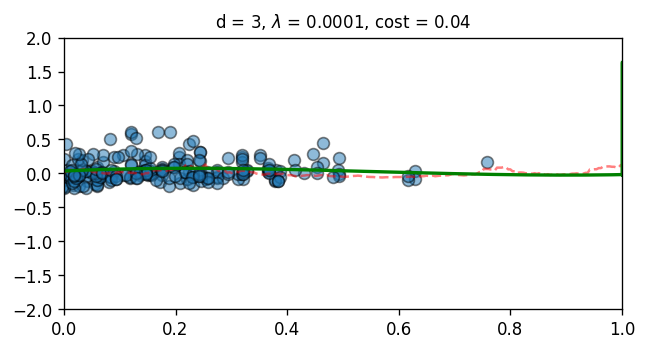

In [154]:
degree = 3
lmbda = 1e-4

# fit
model = fit_poly_L1_reg(degree, lmbda)
scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)

model = fit_poly_L1_reg(degree, lmbda)
scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)

# # plot
plt.figure(figsize=(6,3))
x_test = np.linspace(0, 2, 506)
plt.plot(x_test, y_pred, 'r--', label="Target", alpha=0.5)
plt.scatter(x[:,1], y, s=50, edgecolor='k', alpha=0.5, label="Samples")
x_test = np.vstack((np.ones(len(x_test)),x_test)).T
plt.plot(x_test, model.predict(x_test), 'g', lw=2, label="Predicted")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.title("d = %d, $\lambda$ = %s, cost = %.2f" % (degree, lmbda, -scores.mean()), fontsize=10)
plt.show()

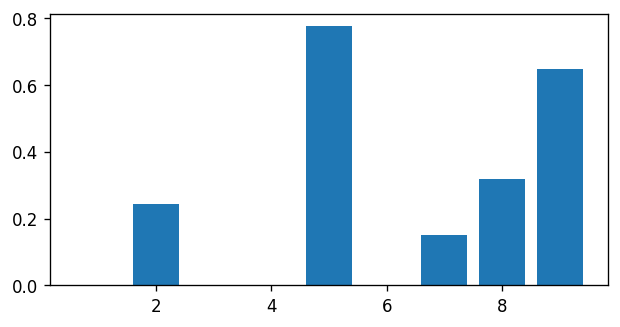

In [155]:
def plot_coef(theta):
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(1, len(theta) + 1), height=np.abs(theta))
    plt.show()
plot_coef(model.steps[1][1].coef_) 

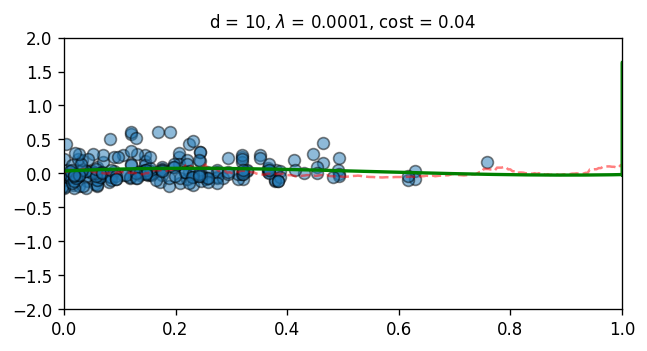

In [156]:
degree = 10
lmbda = 1e-4

# fit
model = fit_poly_L1_reg(degree, lmbda)
scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)

model = fit_poly_L1_reg(degree, lmbda)
scores = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=10)

# # plot
plt.figure(figsize=(6,3))
x_test = np.linspace(0, 2, 506)
plt.plot(x_test, y_pred, 'r--', label="Target", alpha=0.5)
plt.scatter(x[:,1], y, s=50, edgecolor='k', alpha=0.5, label="Samples")
x_test = np.vstack((np.ones(len(x_test)),x_test)).T
plt.plot(x_test, model.predict(x_test), 'g', lw=2, label="Predicted")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.title("d = %d, $\lambda$ = %s, cost = %.2f" % (degree, lmbda, -scores.mean()), fontsize=10)
plt.show()

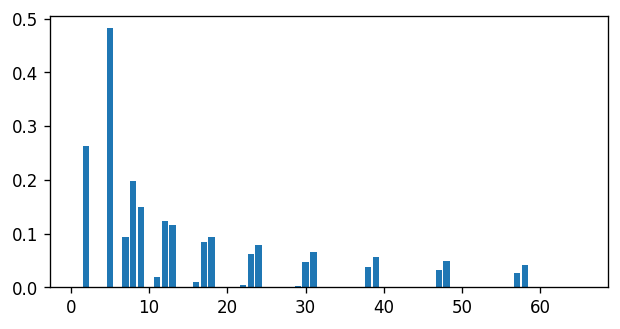

In [157]:
def plot_coef(theta):
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(1, len(theta) + 1), height=np.abs(theta))
    plt.show()
plot_coef(model.steps[1][1].coef_) 

As can be seen, this lasso model puts some coefficients zero. This is because lasso selects the only some feature while reduces the coefficients of others to zero.

## Lasso or Ridge?
We prefer Ridge over lasso in most cases because ridge is mathematically derivative while lasso that is the absolute value is not dervative as it is absolute value.  __Ridge works well if there are many large parameters of about the same value (when most predictors impact the response).__

In some cases, we use lasso penalties and that is when some of the features we are including in our model might be zero . The features do not highly correlate with each other. Hense, we want to perform feature selection but don't want to use wrapper/filter approaches